In [1]:
%matplotlib inline
# %matplotlib notebook
import pandas as pd
import DataHelper
import numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import xgboost as xgb
import sklearn.metrics as metrics

In [2]:
e = DataHelper.eclass_data()

In [3]:
e.cis.Q15.unique()

array([nan, '4 year college', "Master's granting institution",
       'PhD granting institution', '2 year college'], dtype=object)

In [4]:
def return_race(rcode):
    """
    Returns the racial identifier from IPEDS definitions
    
    All 'unknown' columns are reduced to 'Not Reported'
    
    'American Indian or Alaska Native' and 'Native Hawaiian or other Pacific Islander'
    are counted as 'Not Reported' due to the very low numbers (<100) of data gathered for
    them it will not be fair to characterize results of these students
    """
    race_codes = {
#         '10000000':'American Indian or Alaska Native'
        '10000000':'Not Reported'
                  , '01000000':'Asian'
                  , '00100000':'Black'
                  , '00010000':'Hispanic/Latino'
#                   , '00001000':'Native Hawaiian or other Pacific Islander'
                  , '00001000':'Not Reported'
                  , '00000100':'White'
                 }
    try:
        return race_codes[rcode]
    except KeyError:
        return 'Not Reported'

races = e.post.set_index('anon_student_id')[[ 'Q52_1', 'Q52_2', 'Q52_3', 'Q52_4', 'Q52_5', 'Q52_6', 'Q52_7', 'race_unknown']].fillna(0).astype(int).astype(str)

races = (races[ 'Q52_1'] + races['Q52_2'] + races['Q52_3'] + races['Q52_4'] + races['Q52_5'] + races['Q52_6'] + races['Q52_7'] + races['race_unknown'])    

races = races.apply(return_race)
races = pd.DataFrame({'Race':races})


In [5]:
gender = e.post[['anon_student_id','Q54']].drop_duplicates().set_index('anon_student_id')#
gender.columns = ['Gender']

In [6]:
buffy_student = pd.DataFrame(index=pd.concat([e.get_buffy_pre(), e.get_buffy_post()]).anon_student_id.unique())
buffy_student['BUFFY'] = 1

In [7]:
future_plans = e.post[['anon_student_id', 'Q53_1', 'Q53_2', 'Q53_3', 'Q53_4', 'Q53_5', 'Q53_6', 'Q53_7', 'Q53_8']].set_index('anon_student_id')

In [8]:
index = np.arange(0, pd.concat([e.pre.anon_student_id, e.post.anon_student_id]).max()+1, 1)
students = pd.DataFrame(index=index)

students = students.join(races, how='left').join(gender, how='left').join(buffy_student, how='left').join(future_plans).reset_index()
students = students.drop_duplicates(subset=['index'], keep='first').set_index('index').dropna(how='all')
students['BUFFY'] = students['BUFFY'].fillna(0)
students

,Race,Gender,BUFFY,Q53_1,Q53_2,Q53_3,Q53_4,Q53_5,Q53_6,Q53_7,Q53_8
index,,,,,,,,,,,
5,Hispanic/Latino,2.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0
6,White,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
7,White,2.0,0.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0
8,Black,1.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
10,White,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
43076,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43077,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43078,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [9]:
students

,Race,Gender,BUFFY,Q53_1,Q53_2,Q53_3,Q53_4,Q53_5,Q53_6,Q53_7,Q53_8
index,,,,,,,,,,,
5,Hispanic/Latino,2.0,0.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0
6,White,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
7,White,2.0,0.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0
8,Black,1.0,0.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0
10,White,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...
43076,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43077,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
43078,Black,2.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [10]:
e.cis[['Q15', 'anon_instructor_id', 'anon_university_id', 'ResponseId']]

,Q15,anon_instructor_id,anon_university_id,ResponseId
0,NaN,0,0,R_5vvkiNRDrvutGdX
1,4 year college,1,1,R_5mXbzVvsHehQ07L
2,NaN,1,1,R_1g28mGAPrOOZ4Mh
3,4 year college,2,1,R_1pL1oZ2Un6TQfkp
4,4 year college,3,2,R_2ritbcOI1sEN5mn
...,...,...,...,...
594,4 year college,203,132,R_3qJOKOP2r5VyMrj
595,PhD granting institution,69,32,R_3nu6XUP5nAi4lZe
596,NaN,69,32,R_qITeC301YGuhQNr
597,NaN,69,32,R_A72jufifWSmfboZ


In [11]:
alldata = pd.concat([e.pre, e.post])
cis_connector = alldata[['anon_student_id', 'ResponseId']].drop_duplicates().drop_duplicates(subset='anon_student_id').set_index('anon_student_id')
students = students.join(cis_connector).merge(e.cis[['Q15', 'anon_instructor_id', 'anon_university_id', 'ResponseId']])

In [12]:
# data = pd.get_dummies(students)
# data.dropna(inplace=True)

In [13]:
cols = ['Race', 'Gender', 'BUFFY', 'Q53_1', 'Q53_2','Q53_3','Q53_4','Q53_5','Q53_6','Q53_7','Q53_8','Q15','anon_instructor_id','anon_university_id']

pd.get_dummies(students[cols]).columns

Index(['Gender', 'BUFFY', 'Q53_1', 'Q53_2', 'Q53_3', 'Q53_4', 'Q53_5', 'Q53_6',
       'Q53_7', 'Q53_8', 'anon_instructor_id', 'anon_university_id',
       'Race_Asian', 'Race_Black', 'Race_Hispanic/Latino', 'Race_Not Reported',
       'Race_White', 'Q15_2 year college', 'Q15_4 year college',
       'Q15_Master's granting institution', 'Q15_PhD granting institution'],
      dtype='object')

In [14]:
xcols = ['Gender', 'Q53_1', 'Q53_2', 'Q53_3', 'Q53_4', 'Q53_5', 'Q53_6',
       'Q53_7', 'Q53_8'
#          , 'anon_instructor_id', 'anon_university_id','Race_American Indian or Alaska Native'
         , 'Race_Asian', 'Race_Black', 'Race_Hispanic/Latino'
#        'Race_Native Hawaiian or other Pacific Islander'
         , 'Race_Not Reported'
         , 'Race_White'
#          , 'Q15_2 year college'
         , 'Q15_4 year college',
       "Q15_Master's granting institution", 'Q15_PhD granting institution']
ycol = 'BUFFY'

data = pd.get_dummies(students[cols])
data = data[data['Q15_2 year college']==0]
data.dropna(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(data[xcols], data[ycol])

In [15]:
logit_mod = sm.Logit(exog=X_train, endog=y_train)
# logit_res = logit_mod.fit_regularized()
logit_res = logit_mod.fit()
logit_res.summary()

Optimization terminated successfully.
         Current function value: 0.346995
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  BUFFY   No. Observations:                20532
Model:                          Logit   Df Residuals:                    20515
Method:                           MLE   Df Model:                           16
Date:                Mon, 14 Sep 2020   Pseudo R-squ.:                  0.1333
Time:                        17:28:20   Log-Likelihood:                -7124.5
converged:                       True   LL-Null:                       -8220.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Gender                                0.2289      0.045      5.100      0.000       0.141       0.317
Q53_1                                -2.0031      0.055    -36.320      0.000      -2.111      -1.895
Q53_2                                 0.1074      0.046      2.317      0.021       0.017       0.198
Q53_3                                -0.1999      0.049     -4.105      0.000      -0.295      -0.104
Q53_4                                 0.4710      0.065      7.238      0.000       0.343       0.598
Q53_5                                 0.0802      0.061      1.306      0.191      -0.040       0.201
Q53_6                                -0.3268      0.091     -3.579      0.000      -0.506      -0.148
Q53_7                                -0.0126      0.071     -0.179      0.858      -0.151       0.126
Q53_8                                -0.0866      0.070     -1.237      0.216      -0.224       0.051
Race_Asian                            1.4986      0.293      5.115      0.000       0.924       2.073
Race_Black                            0.6892      0.315      2.187      0.029       0.072       1.307
Race_Hispanic/Latino                  1.1857      0.306      3.875      0.000       0.586       1.785
Race_Not Reported                     1.4345      0.293      4.899      0.000       0.861       2.008
Race_White                            1.6253      0.291      5.589      0.000       1.055       2.195
Q15_4 year college                    0.6258      0.083      7.572      0.000       0.464       0.788
Q15_Master's granting institution    -0.9664      0.147     -6.593      0.000      -1.254      -0.679
Q15_PhD granting institution         -0.4403      0.053     -8.326      0.000      -0.544      -0.337
=====================================================================================================
"""

In [16]:
preds = logit_res.predict(X_test)
metrics.roc_auc_score(y_true=y_test, y_score=preds)

0.726409048317805

In [17]:
X_train.join(y_train)

,Gender,Q53_1,Q53_2,Q53_3,Q53_4,Q53_5,Q53_6,Q53_7,Q53_8,Race_Asian,Race_Black,Race_Hispanic/Latino,Race_Not Reported,Race_White,Q15_4 year college,Q15_Master's granting institution,Q15_PhD granting institution,BUFFY
13608,2.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,0,0,0,0,1,0,0,1,0.0
25403,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,0,0,0,0,1,1,0,0,0.0
27192,2.0,2.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,0,0,0,0,1,0,0,0,0.0
20907,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,1,0,0,0,1,0,0.0
17579,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,0,0,0,0,1,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9676,2.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,2.0,1,0,0,0,0,0,0,1,0.0
22791,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,0,0,0,0,1,0,0,0,0.0
19989,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,0,0,0,1,0,0,0,1,0.0
14942,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,0,0,0,0,1,0,0,0,0.0


In [24]:
dtrain = xgb.DMatrix(X_train, label=y_train, missing=-999.0)
dtest = xgb.DMatrix(X_test, label=y_test, missing=-999.0)

# param = {'max_depth': 5, 'eta': 0.3, 'objective': 'binary:logistic'}
param = {'max_depth': 2, 'eta': 0.3, 'objective': 'reg:logistic'}
# param = {'max_depth': 2, 'booster': 'gblinear', 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
param['scale_pos_weight'] = data.BUFFY.count()/data.BUFFY.sum()

num_round = 30000
bst = xgb.train(param, dtrain, num_round)

In [25]:
classify = lambda x: 0 if x < 0.5 else 1
preds = [classify(y) for y in bst.predict(dtest)]
metrics.roc_auc_score(y_true=y_test, y_score=preds)

0.6765693415601483

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

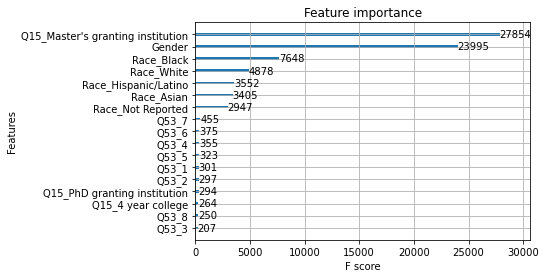

In [26]:
xgb.plot_importance(bst)

In [27]:
np.sqrt(17)

4.123105625617661

In [22]:
data.corr()

,Gender,BUFFY,Q53_1,Q53_2,Q53_3,Q53_4,Q53_5,Q53_6,Q53_7,Q53_8,...,anon_university_id,Race_Asian,Race_Black,Race_Hispanic/Latino,Race_Not Reported,Race_White,Q15_2 year college,Q15_4 year college,Q15_Master's granting institution,Q15_PhD granting institution
Gender,1.000000,0.075698,-0.102431,0.040716,-0.091278,0.186526,0.152434,0.010693,-0.040307,-0.044895,...,-0.040924,-0.008544,-0.069862,0.029746,0.011244,0.016643,NaN,-0.009385,0.046529,0.006987
BUFFY,0.075698,1.000000,-0.342158,-0.002919,-0.074834,0.097884,0.029003,-0.068530,-0.104819,-0.027369,...,0.020600,0.000242,-0.058696,-0.031742,-0.001546,0.044223,NaN,0.093254,-0.046490,-0.042988
Q53_1,-0.102431,-0.342158,1.000000,0.039107,0.100621,-0.135924,-0.057607,0.114212,0.274854,0.034723,...,0.018761,0.005590,0.048101,0.013309,-0.031056,-0.011324,NaN,-0.071389,0.021882,-0.031774
Q53_2,0.040716,-0.002919,0.039107,1.000000,0.177033,-0.047722,0.044323,0.067334,0.192734,-0.017796,...,-0.004606,-0.022110,0.024037,0.010002,-0.000438,0.001776,NaN,-0.022655,0.008549,-0.009571
Q53_3,-0.091278,-0.074834,0.100621,0.177033,1.000000,-0.198945,-0.011092,0.076063,0.094233,0.183830,...,0.021421,0.038346,0.047725,0.014712,0.002987,-0.062527,NaN,0.000285,-0.000428,-0.050401
Q53_4,0.186526,0.097884,-0.135924,-0.047722,-0.198945,1.000000,-0.018577,-0.050845,-0.067873,-0.091679,...,-0.044601,0.004212,-0.069092,0.017894,0.004822,0.016591,NaN,0.008357,0.062553,0.008063
Q53_5,0.152434,0.029003,-0.057607,0.044323,-0.011092,-0.018577,1.000000,0.016004,0.009114,0.106629,...,-0.004673,0.018523,-0.047525,0.031331,0.004065,-0.011119,NaN,-0.014784,0.043543,0.030170
Q53_6,0.010693,-0.068530,0.114212,0.067334,0.076063,-0.050845,0.016004,1.000000,0.345741,0.095475,...,0.006740,0.001207,0.010197,-0.025549,-0.010296,0.014393,NaN,-0.015198,-0.012959,-0.012238
Q53_7,-0.040307,-0.104819,0.274854,0.192734,0.094233,-0.067873,0.009114,0.345741,1.000000,0.070721,...,0.015283,-0.014205,0.025102,-0.011191,-0.028503,0.025674,NaN,-0.001650,-0.015485,-0.021257
Q53_8,-0.044895,-0.027369,0.034723,-0.017796,0.183830,-0.091679,0.106629,0.095475,0.070721,1.000000,...,0.001889,-0.010391,0.005138,0.011620,-0.013168,0.009579,NaN,-0.013013,0.003948,-0.015449


In [23]:
students.groupby(['Race', 'Gender', 'BUFFY']).count()/students.groupby(['Race', 'Gender']).count()

BUFFY       Q15     Q53_1     Q53_2     Q53_3  \
Race            Gender BUFFY                                                  
Asian           1.0    0.0      NaN  0.906032  0.892068  0.892068  0.892068   
                       1.0      NaN  0.093968  0.107932  0.107932  0.107932   
                2.0    0.0      NaN  0.878049  0.843938  0.843938  0.843938   
                       1.0      NaN  0.121951  0.156062  0.156062  0.156062   
                3.0    0.0      NaN  0.900000  0.785714  0.785714  0.785714   
                       1.0      NaN  0.100000  0.214286  0.214286  0.214286   
Black           1.0    0.0      NaN  0.945701  0.961883  0.961883  0.961883   
                       1.0      NaN  0.054299  0.038117  0.038117  0.038117   
                2.0    0.0      NaN  0.907216  0.923851  0.923851  0.923851   
                       1.0      NaN  0.092784  0.076149  0.076149  0.076149   
                3.0    0.0      NaN  0.800000  0.900000  0.900000  0.900000   
                       1.0      NaN  0.200000  0.100000  0.100000  0.100000   
Hispanic/Latino 1.0    0.0      NaN  0.955696  0.923313  0.923313  0.923313   
                       1.0      NaN  0.044304  0.076687  0.076687  0.076687   
                2.0    0.0      NaN  0.940870  0.896283  0.896283  0.896283   
                       1.0      NaN  0.059130  0.103717  0.103717  0.103717   
                3.0    0.0      NaN  1.000000  0.733333  0.733333  0.733333   
                       1.0      NaN  0.000000  0.266667  0.266667  0.266667   
Not Reported    1.0    0.0      NaN  0.892077  0.897260  0.897260  0.897260   
                       1.0      NaN  0.107923  0.102740  0.102740  0.102740   
                2.0    0.0      NaN  0.863089  0.847252  0.847252  0.847252   
                       1.0      NaN  0.136911  0.152748  0.152748  0.152748   
                3.0    0.0      NaN  0.837838  0.743363  0.743363  0.743363   
                       1.0      NaN  0.162162  0.256637  0.256637  0.256637   
White           1.0    0.0      NaN  0.862735  0.880620  0.880620  0.880620   
                       1.0      NaN  0.137265  0.119380  0.119380  0.119380   
                2.0    0.0      NaN  0.841799  0.828994  0.828994  0.828994   
                       1.0      NaN  0.158201  0.171006  0.171006  0.171006   
                3.0    0.0      NaN  0.880000  0.833333  0.833333  0.833333   
                       1.0      NaN  0.120000  0.166667  0.166667  0.166667   

                                 Q53_4     Q53_5     Q53_6     Q53_7  \
Race            Gender BUFFY                                           
Asian           1.0    0.0    0.892068  0.892068  0.892068  0.892068   
                       1.0    0.107932  0.107932  0.107932  0.107932   
                2.0    0.0    0.843938  0.843938  0.843938  0.843938   
                       1.0    0.156062  0.156062  0.156062  0.156062   
                3.0    0.0    0.785714  0.785714  0.785714  0.785714   
                       1.0    0.214286  0.214286  0.214286  0.214286   
Black           1.0    0.0    0.961883  0.961883  0.961883  0.961883   
                       1.0    0.038117  0.038117  0.038117  0.038117   
                2.0    0.0    0.923851  0.923851  0.923851  0.923851   
                       1.0    0.076149  0.076149  0.076149  0.076149   
                3.0    0.0    0.900000  0.900000  0.900000  0.900000   
                       1.0    0.100000  0.100000  0.100000  0.100000   
Hispanic/Latino 1.0    0.0    0.923313  0.923313  0.923313  0.923313   
                       1.0    0.076687  0.076687  0.076687  0.076687   
                2.0    0.0    0.896283  0.896283  0.896283  0.896283   
                       1.0    0.103717  0.103717  0.103717  0.103717   
                3.0    0.0    0.733333  0.733333  0.733333  0.733333   
                       1.0    0.266667  0.266667  0.266667  0.266667   
Not Reported    1.0    0.0    0.897260  0.897260  0.897260  0